In [1]:
from tdavec.TDAvectorizer import TDAvectorizer, createEllipse
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

Hello from tdavec


Let us create some set of squezzed ellipses:

In [2]:
np.random.seed(42)
epsList = np.random.uniform(low = 0, high = 1, size = 500)
np.savetxt("../R/epsList.csv", epsList)
clouds = [createEllipse(a=1, b=eps, n=100) for eps in epsList]

Here are some examples:

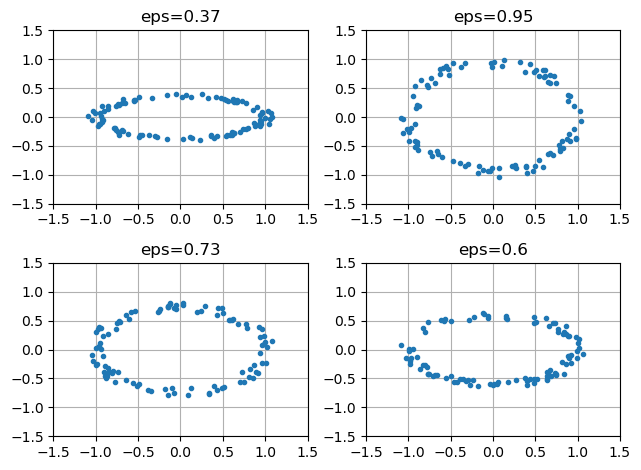

In [3]:
for i, cl in enumerate(clouds[:4]):
    plt.subplot(2, 2, i+1)
    plt.plot(cl[:,0], cl[:,1], ".")
    plt.xlim(-1.5, 1.5); plt.ylim(-1.5, 1.5)
    plt.title(f"eps={np.round(epsList[i], 2)}")
    plt.grid()
plt.tight_layout()

In [4]:
v = TDAvectorizer()
v.setParams({"scale":np.linspace(0, 2, 10)})
v.fit(clouds)

Here are the examples of the generated persistence diagrams:

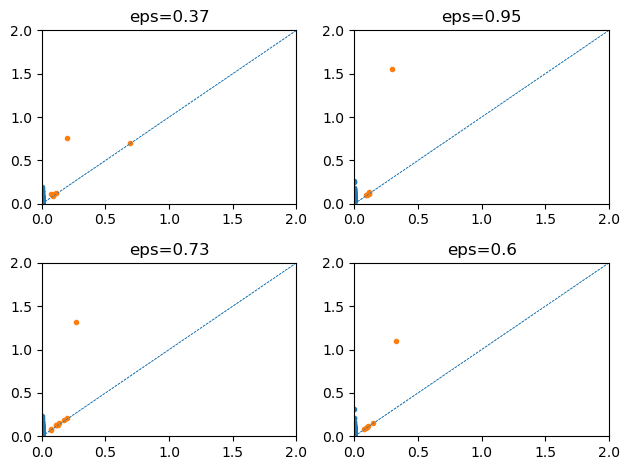

In [5]:
for i in range(4):
    plt.subplot(2,2,i+1)
    PD = v.diags[i]
    for dim in range(2):
        plt.plot(PD[dim][:,0], PD[dim][:,1], ".")
        plt.xlim(0, 2); plt.ylim(0, 2)
        plt.axline( (0,0), slope = 1, linestyle = "--", linewidth = 0.5)
        plt.title(f"eps={np.round(epsList[i], 2)}")
plt.tight_layout()

Here are some PS plots

In [6]:
len(v.params["scale"])

10

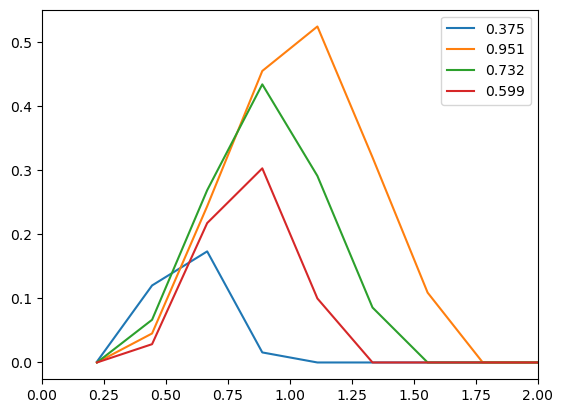

In [11]:
X = v.transform(output="PS", homDim=1)
for i, e in enumerate(epsList[:4]):
    plt.plot(v.getParams()["scale"][1:],X[i,:], label=np.round(e, 3))
    plt.xlim(0, 2)
plt.legend()


Let us now check different vectorization methods

Here is a function that uses specified vectorization method to solve the regression task and guess the squese factor:

In [13]:
v.setParams({"scale":np.linspace(0, 2, 30)})
methodList = ["VAB", "PS", "NL", "ECC", "FDA"]
def makeSim(method, homDim, vec = v, y=epsList):
    X =v.transform(output=method, homDim=homDim)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.8, random_state=42)
    model = LinearRegression().fit(Xtrain, ytrain)
    test_preds = model.predict(Xtest)
    score = model.score(Xtest, ytest)
    res = {"method":method, "homDim":homDim, "test_preds":test_preds, "y_test":ytest, "score":score}
    return res

Ib the loop below we collect performace statistics for different vectorization methods:

In [14]:
results = []
df = pd.DataFrame()
for homDim in [0, 1]:
    print(f" Dimension {dim}: ", end=" ")
    for method in methodList:
        print(method, end = " ")
        res = makeSim(method, homDim); results.append(res)
        df = pd.concat([df, pd.DataFrame(res)])
    print()
# df = df[["method", "homDim", "score"]].drop_duplicates()

df["homDim"] = df["homDim"].astype("category")

 Dimension 1:  VAB PS NL ECC FDA 
 Dimension 1:  VAB PS NL ECC FDA 


Here is the regression scores table for different vetcorizations 

In [15]:
df[["method", "homDim", "score"]].drop_duplicates().pivot(index="method", columns="homDim", values="score")

homDim,0,1
method,,
ECC,0.976142,0.996198
FDA,0.983050,0.984793
NL,0.893031,0.980520
PS,0.903171,0.913956
VAB,0.976142,0.985684


As you can see, they are very close to 1, so fits are pretty accurate

The same can be easily seen from presented below scatter plots whrere for each dimension and method true and predicted values if the ellipse squese factor are shown on horizontal and vertical axes.

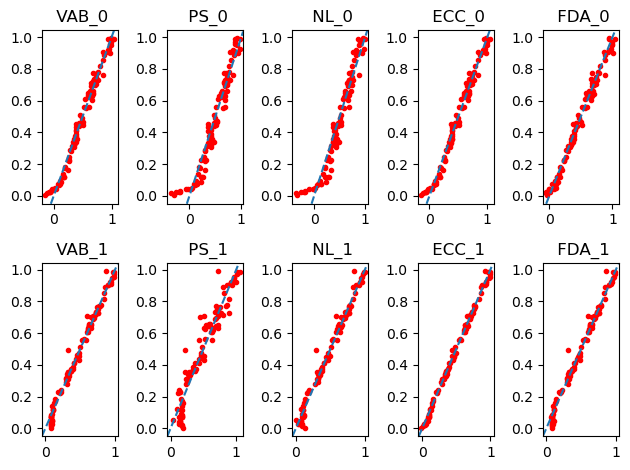

In [16]:
for i, r in enumerate(results):
    plt.subplot(2, 5, i+1)
    plt.plot(r["test_preds"], r["y_test"], "r.")
    plt.axline( (0,0), slope=1, linestyle = "--")
    plt.title(" {}_{}".format(r["method"], r["homDim"]))
plt.tight_layout()